In [6]:
import torch

In [7]:
# Check device availability
device = ''
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
device = torch.device(device)
print("You are using device: %s" % device)

You are using device: mps


In [8]:
SAMPLE_DATA_FILE = 'data/sample.csv'
LABELS_OUTPUT = 'data/labels_multi_hot.pt'
W2V_EMBEDDED_VISIT_NOTES_OUTPUT = 'data/w2v_embedded_visit_notes.pt'
D2V_EMBEDDED_VISIT_NOTES_OUTPUT = 'data/d2v_embedded_visit_notes.pt'

In [9]:
import pandas as pd

# Printing raw data from data file
df = pd.read_csv(SAMPLE_DATA_FILE)
print(df)

       case_num  subject_id icd9_code  \
0             0           0   S8264XJ   
1             0           1   S36501D   
2             0           2   T484X2A   
3             0           3   S86301D   
4             0           4     M9948   
...         ...         ...       ...   
42141         9       95330   S82854H   
42142         9       95331     A1839   
42143         9       95332    M12842   
42144         9       95333   M84522S   
42145         9       95334   O6022X1   

                                                    text  
0      17-year-old male, has come to the student heal...  
1      17 yo male with recurrent palpitations for the...  
2      Dillon Cleveland is a 17 y.o. male patient wit...  
3      a 17 yo m c/o palpitation started 3 mos ago; \...  
4      17yo male with no pmh here for evaluation of p...  
...                                                  ...  
42141  Ms. Madden is a 20 yo female presenting w/ the...  
42142  A 20 YO F CAME COMPLAIN A DU

In [10]:
# Load embedded visit notes
d2v_embedded_visit_notes = torch.load(D2V_EMBEDDED_VISIT_NOTES_OUTPUT, weights_only=True)
w2v_embedded_visit_notes = torch.load(W2V_EMBEDDED_VISIT_NOTES_OUTPUT, weights_only=True)
labels = torch.load(LABELS_OUTPUT, weights_only=True)
print(d2v_embedded_visit_notes.shape)
print(w2v_embedded_visit_notes.shape)
print(labels.shape)

D2V_VECTOR_SIZE = d2v_embedded_visit_notes.shape[1]
W2V_VECTOR_SIZE = w2v_embedded_visit_notes.shape[1]

torch.Size([52722, 128])
torch.Size([52722, 100, 700])
torch.Size([52722, 6918])


In [11]:
embedded_visit_notes = [(d2v, w2v) for d2v, w2v in zip(d2v_embedded_visit_notes, w2v_embedded_visit_notes)]

In [12]:
import numpy as np
from torch.utils.data import DataLoader

from utils import ICD9_Dataset


percentage = 0.5
batch_size = 50

num_samples = int(np.floor(percentage * labels.shape[0]))
train_samples = int(np.floor(0.7 * num_samples))
leftovers = num_samples - train_samples
valid_samples = train_samples + int(np.floor(0.5*leftovers))

print("Total Samples: ", str(num_samples))
print("Train Samples: ", str(train_samples))
print("Valid Samples: ", str(valid_samples - train_samples))
print("Test Samples: ", str(num_samples - valid_samples))


# Initialize Dataset
train_dataset = ICD9_Dataset(embedded_visit_notes[:train_samples],
                              labels[:train_samples])
valid_dataset = ICD9_Dataset(embedded_visit_notes[train_samples:valid_samples],
                            labels[train_samples:valid_samples])
test_dataset = ICD9_Dataset(embedded_visit_notes[valid_samples:num_samples],
                              labels[valid_samples:num_samples])
# Initialize DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

Total Samples:  26361
Train Samples:  18452
Valid Samples:  3954
Test Samples:  3955


In [13]:
sample_set = embedded_visit_notes[0:5]
sample_set_d2v, sample_set_w2v = zip(*sample_set)
sample_set_d2v = torch.stack(sample_set_d2v)  
sample_set_w2v = torch.stack(sample_set_w2v)
print(sample_set_d2v.shape)
print(sample_set_w2v.shape)

torch.Size([5, 128])
torch.Size([5, 100, 700])


In [14]:
# Use CNN to process sample set of vector

import cnn 

my_cnn = cnn.CNN(device=device).to(device)

x = sample_set_w2v.to(device)
print(x.shape)

output = my_cnn.forward(x)
print(output.shape)


torch.Size([5, 100, 700])
torch.Size([5, 192])


In [15]:
# Use D2V Linear Layer to process sample set of vector

import importlib
import d2v_fc 

importlib.reload(d2v_fc)

dv2_model = d2v_fc.D2VFullyConnectedLayer(device=device).to(device)

x = sample_set_d2v.to(device)
print(x.shape)

output = dv2_model.forward(x)
print(output.shape)

torch.Size([5, 128])
torch.Size([5, 128])


In [16]:
# Use Combined Model to process sample set of data

import importlib
import icd9_dl_model 

importlib.reload(icd9_dl_model)
model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1]).to(device)

x = (sample_set_d2v, sample_set_w2v)

output = model.forward(x)
print(output)

tensor([[ 0.4491, -0.3519,  0.1775,  ..., -0.6958, -0.8233, -0.6295],
        [-0.8394, -0.1335, -1.2433,  ..., -0.8375,  0.0779, -0.6620],
        [ 0.8663, -0.2735,  0.1661,  ..., -1.4716, -0.1585,  0.3135],
        [-0.0736, -1.0872, -0.4770,  ..., -0.5016, -1.8017,  0.0959],
        [ 0.6756,  0.1269, -0.1067,  ..., -1.5061,  0.2839, -0.0291]],
       device='mps:0', grad_fn=<LinearBackward0>)


In [24]:
from utils import train, evaluate, plot_curves
import torch.nn as nn

def train_and_plot(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, filename='', epochs=10, threshold=0.2):
    train_accuracies = []
    valid_accuracies = []
    train_losses = []
    valid_losses = []
    for epoch_idx in range(epochs):
        print("-----------------------------------")
        print("Epoch %d" % (epoch_idx+1))
        print("-----------------------------------")

        train_accuracy, train_loss, train_precision, train_recall, train_f1 = train(model, train_loader, criterion, optimizer, device=device, threshold=threshold)

        if scheduler:
            scheduler.step(train_loss)

        valid_accuracy, valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(model, valid_loader, criterion, device=device, threshold=threshold)

        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print("Training Loss: %.4f. Validation Loss: %.4f. " % (train_loss, valid_loss))
        print("Training Accuracy: %.4f. Validation Accuracy: %.4f. " % (train_accuracy, valid_accuracy))
        print("Training Precision: %.4f. Validation Precision: %.4f. " % (train_precision, valid_precision))
        print("Training Recall: %.4f. Validation Recall: %.4f. " % (train_recall, valid_recall))
        print("Training F1: %.4f. Validation F1: %.4f. " % (train_f1, valid_f1))

    plot_curves(train_accuracies, valid_accuracies, "Accuracy", filename, output_dir='outputs/')
    plot_curves(train_losses, valid_losses, "Loss", filename, output_dir='outputs/')

-----------------------------------
Epoch 1
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 63.35it/s]


Training Loss: 78.4490. Validation Loss: 73.5853. 
Training Accuracy: 0.9531. Validation Accuracy: 0.9567. 
Training Precision: 0.0253. Validation Precision: 0.0289. 
Training Recall: 0.6951. Validation Recall: 0.7516. 
Training F1: 0.0489. Validation F1: 0.0557. 
-----------------------------------
Epoch 2
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 58.81it/s]


Training Loss: 73.0931. Validation Loss: 71.6746. 
Training Accuracy: 0.9536. Validation Accuracy: 0.9547. 
Training Precision: 0.0274. Validation Precision: 0.0289. 
Training Recall: 0.7657. Validation Recall: 0.7880. 
Training F1: 0.0528. Validation F1: 0.0557. 
-----------------------------------
Epoch 3
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 60.27it/s]


Training Loss: 71.6767. Validation Loss: 71.3731. 
Training Accuracy: 0.9482. Validation Accuracy: 0.9515. 
Training Precision: 0.0255. Validation Precision: 0.0280. 
Training Recall: 0.7944. Validation Recall: 0.8099. 
Training F1: 0.0494. Validation F1: 0.0541. 
-----------------------------------
Epoch 4
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 73.00it/s]


Training Loss: 71.1081. Validation Loss: 70.2387. 
Training Accuracy: 0.9438. Validation Accuracy: 0.9491. 
Training Precision: 0.0240. Validation Precision: 0.0269. 
Training Recall: 0.8108. Validation Recall: 0.8228. 
Training F1: 0.0467. Validation F1: 0.0520. 
-----------------------------------
Epoch 5
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 57.28it/s]


Training Loss: 70.7296. Validation Loss: 70.5930. 
Training Accuracy: 0.9409. Validation Accuracy: 0.9486. 
Training Precision: 0.0232. Validation Precision: 0.0269. 
Training Recall: 0.8206. Validation Recall: 0.8274. 
Training F1: 0.0451. Validation F1: 0.0521. 
-----------------------------------
Epoch 6
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 58.23it/s]


Training Loss: 70.6410. Validation Loss: 69.6938. 
Training Accuracy: 0.9399. Validation Accuracy: 0.9465. 
Training Precision: 0.0230. Validation Precision: 0.0261. 
Training Recall: 0.8278. Validation Recall: 0.8403. 
Training F1: 0.0447. Validation F1: 0.0506. 
-----------------------------------
Epoch 7
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 68.66it/s]


Training Loss: 70.4953. Validation Loss: 69.7413. 
Training Accuracy: 0.9382. Validation Accuracy: 0.9462. 
Training Precision: 0.0225. Validation Precision: 0.0259. 
Training Recall: 0.8324. Validation Recall: 0.8388. 
Training F1: 0.0437. Validation F1: 0.0502. 
-----------------------------------
Epoch 8
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 68.36it/s]


Training Loss: 70.2891. Validation Loss: 70.1720. 
Training Accuracy: 0.9374. Validation Accuracy: 0.9454. 
Training Precision: 0.0222. Validation Precision: 0.0258. 
Training Recall: 0.8351. Validation Recall: 0.8418. 
Training F1: 0.0433. Validation F1: 0.0500. 
-----------------------------------
Epoch 9
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 62.25it/s]


Training Loss: 70.1911. Validation Loss: 69.6931. 
Training Accuracy: 0.9366. Validation Accuracy: 0.9459. 
Training Precision: 0.0220. Validation Precision: 0.0259. 
Training Recall: 0.8388. Validation Recall: 0.8424. 
Training F1: 0.0430. Validation F1: 0.0503. 
-----------------------------------
Epoch 10
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 68.59it/s]


Training Loss: 70.0510. Validation Loss: 69.7053. 
Training Accuracy: 0.9356. Validation Accuracy: 0.9458. 
Training Precision: 0.0218. Validation Precision: 0.0259. 
Training Recall: 0.8422. Validation Recall: 0.8432. 
Training F1: 0.0425. Validation F1: 0.0503. 


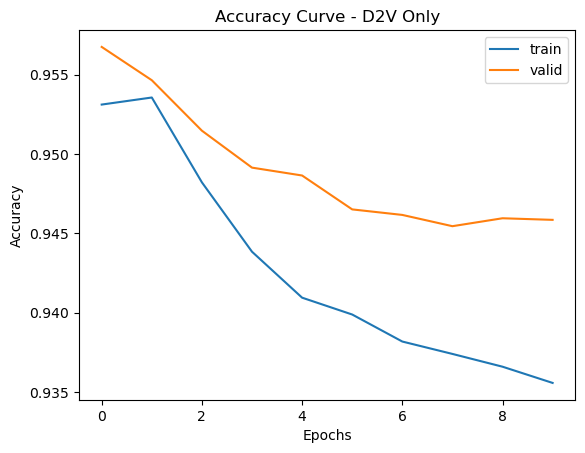

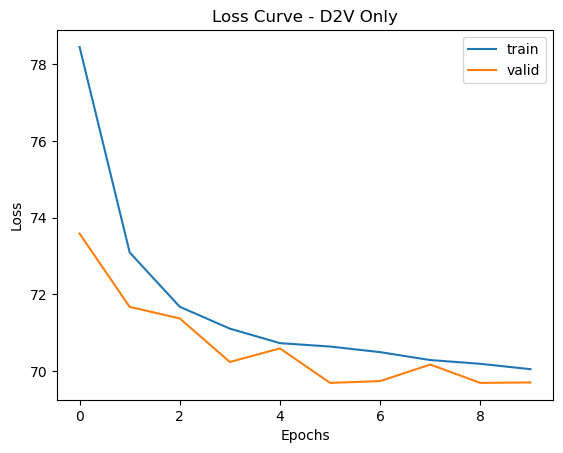

In [21]:
# D2V Only

import icd9_dl_model

learning_rate = 0.001
model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1], specific_model="d2v").to(device)
scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10
file_name = "D2V Only"
threshold = 0.2

train_and_plot(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, filename=file_name, threshold=0.2)

-----------------------------------
Epoch 1
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 35.75it/s]


Training Loss: 78.3783. Validation Loss: 74.4258. 
Training Accuracy: 0.9697. Validation Accuracy: 0.9789. 
Training Precision: 0.0384. Validation Precision: 0.0482. 
Training Recall: 0.5824. Validation Recall: 0.6095. 
Training F1: 0.0719. Validation F1: 0.0894. 
-----------------------------------
Epoch 2
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 41.93it/s]


Training Loss: 74.4086. Validation Loss: 72.6499. 
Training Accuracy: 0.9781. Validation Accuracy: 0.9805. 
Training Precision: 0.0466. Validation Precision: 0.0536. 
Training Recall: 0.6167. Validation Recall: 0.6327. 
Training F1: 0.0867. Validation F1: 0.0988. 
-----------------------------------
Epoch 3
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.31it/s]


Training Loss: 73.1467. Validation Loss: 72.3168. 
Training Accuracy: 0.9799. Validation Accuracy: 0.9821. 
Training Precision: 0.0522. Validation Precision: 0.0595. 
Training Recall: 0.6334. Validation Recall: 0.6415. 
Training F1: 0.0965. Validation F1: 0.1089. 
-----------------------------------
Epoch 4
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 32.95it/s]


Training Loss: 72.2997. Validation Loss: 70.9607. 
Training Accuracy: 0.9811. Validation Accuracy: 0.9837. 
Training Precision: 0.0561. Validation Precision: 0.0654. 
Training Recall: 0.6409. Validation Recall: 0.6458. 
Training F1: 0.1031. Validation F1: 0.1187. 
-----------------------------------
Epoch 5
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.52it/s]


Training Loss: 71.5137. Validation Loss: 70.1750. 
Training Accuracy: 0.9822. Validation Accuracy: 0.9847. 
Training Precision: 0.0594. Validation Precision: 0.0693. 
Training Recall: 0.6403. Validation Recall: 0.6477. 
Training F1: 0.1086. Validation F1: 0.1251. 
-----------------------------------
Epoch 6
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 42.86it/s]


Training Loss: 70.8735. Validation Loss: 69.8945. 
Training Accuracy: 0.9831. Validation Accuracy: 0.9862. 
Training Precision: 0.0626. Validation Precision: 0.0757. 
Training Recall: 0.6415. Validation Recall: 0.6356. 
Training F1: 0.1140. Validation F1: 0.1351. 
-----------------------------------
Epoch 7
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.87it/s]


Training Loss: 70.4950. Validation Loss: 69.4293. 
Training Accuracy: 0.9839. Validation Accuracy: 0.9866. 
Training Precision: 0.0651. Validation Precision: 0.0783. 
Training Recall: 0.6355. Validation Recall: 0.6398. 
Training F1: 0.1181. Validation F1: 0.1394. 
-----------------------------------
Epoch 8
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 34.18it/s]


Training Loss: 69.8453. Validation Loss: 69.7608. 
Training Accuracy: 0.9848. Validation Accuracy: 0.9874. 
Training Precision: 0.0681. Validation Precision: 0.0813. 
Training Recall: 0.6301. Validation Recall: 0.6237. 
Training F1: 0.1228. Validation F1: 0.1437. 
-----------------------------------
Epoch 9
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 31.08it/s]


Training Loss: 69.5871. Validation Loss: 69.3353. 
Training Accuracy: 0.9853. Validation Accuracy: 0.9881. 
Training Precision: 0.0703. Validation Precision: 0.0858. 
Training Recall: 0.6269. Validation Recall: 0.6199. 
Training F1: 0.1263. Validation F1: 0.1507. 
-----------------------------------
Epoch 10
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 36.17it/s]


Training Loss: 69.1402. Validation Loss: 69.1729. 
Training Accuracy: 0.9861. Validation Accuracy: 0.9887. 
Training Precision: 0.0735. Validation Precision: 0.0888. 
Training Recall: 0.6203. Validation Recall: 0.6097. 
Training F1: 0.1312. Validation F1: 0.1550. 


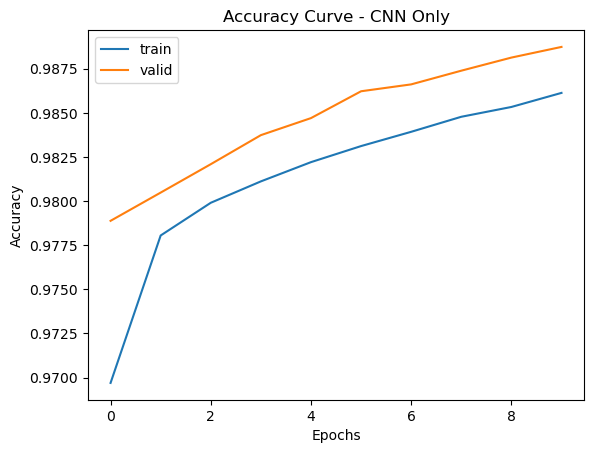

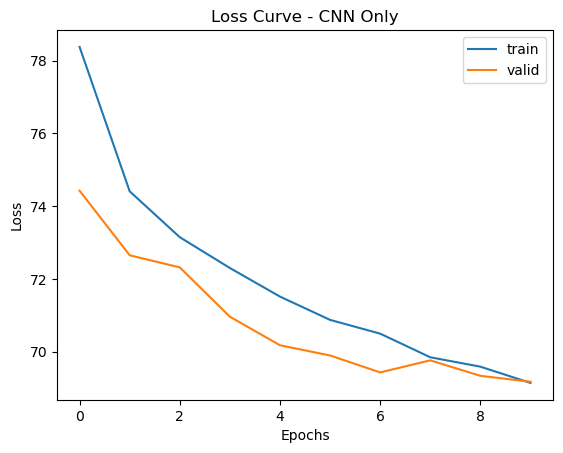

In [22]:
# CNN Only

import icd9_dl_model 

learning_rate = 0.001
model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1], specific_model="cnn").to(device)
scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10
file_name = "CNN Only"
threshold = 0.2

train_and_plot(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, filename=file_name, threshold=0.2)

-----------------------------------
Epoch 1
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 32.93it/s]


Training Loss: 76.0217. Validation Loss: 72.0967. 
Training Accuracy: 0.9706. Validation Accuracy: 0.9757. 
Training Precision: 0.0397. Validation Precision: 0.0472. 
Training Recall: 0.6254. Validation Recall: 0.6906. 
Training F1: 0.0746. Validation F1: 0.0883. 
-----------------------------------
Epoch 2
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:03<00:00, 25.87it/s]


Training Loss: 71.7733. Validation Loss: 70.1347. 
Training Accuracy: 0.9696. Validation Accuracy: 0.9732. 
Training Precision: 0.0389. Validation Precision: 0.0452. 
Training Recall: 0.7065. Validation Recall: 0.7346. 
Training F1: 0.0736. Validation F1: 0.0852. 
-----------------------------------
Epoch 3
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 34.62it/s]


Training Loss: 70.2084. Validation Loss: 69.4477. 
Training Accuracy: 0.9671. Validation Accuracy: 0.9729. 
Training Precision: 0.0373. Validation Precision: 0.0455. 
Training Recall: 0.7371. Validation Recall: 0.7461. 
Training F1: 0.0710. Validation F1: 0.0857. 
-----------------------------------
Epoch 4
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 28.69it/s]


Training Loss: 69.4007. Validation Loss: 68.4039. 
Training Accuracy: 0.9669. Validation Accuracy: 0.9731. 
Training Precision: 0.0377. Validation Precision: 0.0462. 
Training Recall: 0.7523. Validation Recall: 0.7578. 
Training F1: 0.0718. Validation F1: 0.0871. 
-----------------------------------
Epoch 5
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 37.27it/s]


Training Loss: 68.7827. Validation Loss: 68.0651. 
Training Accuracy: 0.9677. Validation Accuracy: 0.9749. 
Training Precision: 0.0387. Validation Precision: 0.0492. 
Training Recall: 0.7553. Validation Recall: 0.7518. 
Training F1: 0.0736. Validation F1: 0.0924. 
-----------------------------------
Epoch 6
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 46.34it/s]


Training Loss: 68.2818. Validation Loss: 68.1890. 
Training Accuracy: 0.9690. Validation Accuracy: 0.9769. 
Training Precision: 0.0404. Validation Precision: 0.0528. 
Training Recall: 0.7546. Validation Recall: 0.7433. 
Training F1: 0.0767. Validation F1: 0.0986. 
-----------------------------------
Epoch 7
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 44.69it/s]


Training Loss: 67.9427. Validation Loss: 67.3700. 
Training Accuracy: 0.9705. Validation Accuracy: 0.9774. 
Training Precision: 0.0421. Validation Precision: 0.0538. 
Training Recall: 0.7492. Validation Recall: 0.7421. 
Training F1: 0.0796. Validation F1: 0.1002. 
-----------------------------------
Epoch 8
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 43.14it/s]


Training Loss: 67.3689. Validation Loss: 67.4191. 
Training Accuracy: 0.9720. Validation Accuracy: 0.9795. 
Training Precision: 0.0440. Validation Precision: 0.0580. 
Training Recall: 0.7455. Validation Recall: 0.7275. 
Training F1: 0.0830. Validation F1: 0.1074. 
-----------------------------------
Epoch 9
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 42.96it/s]


Training Loss: 67.0104. Validation Loss: 67.3045. 
Training Accuracy: 0.9734. Validation Accuracy: 0.9804. 
Training Precision: 0.0459. Validation Precision: 0.0603. 
Training Recall: 0.7389. Validation Recall: 0.7211. 
Training F1: 0.0864. Validation F1: 0.1112. 
-----------------------------------
Epoch 10
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 45.13it/s]


Training Loss: 66.8847. Validation Loss: 67.0805. 
Training Accuracy: 0.9748. Validation Accuracy: 0.9814. 
Training Precision: 0.0480. Validation Precision: 0.0625. 
Training Recall: 0.7305. Validation Recall: 0.7123. 
Training F1: 0.0900. Validation F1: 0.1148. 


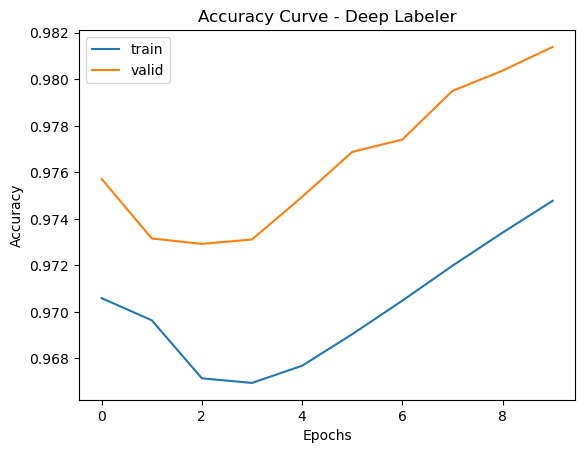

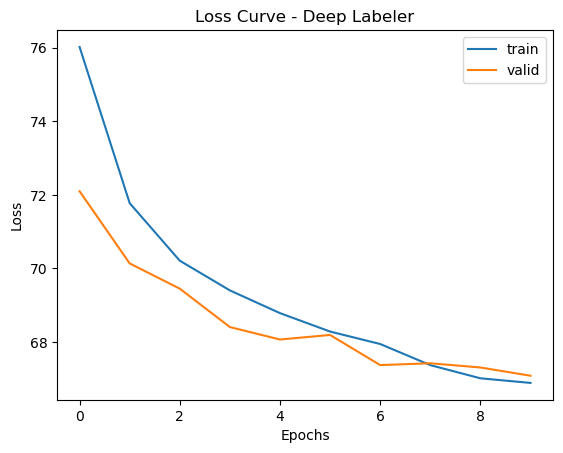

In [23]:
# Combined Deep Labeler

import icd9_dl_model 

learning_rate = 0.001
model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1]).to(device)
scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10
file_name = "Deep Labeler"
threshold = 0.2

train_and_plot(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, filename=file_name, threshold=0.2)